Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/9614 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning on combined dataset...


Epoch,Training Loss,Validation Loss
1,0.001200,0.013907
2,0.013400,0.012455
3,0.027000,0.015947


Topics saved to 'extracted_topics_combined_refined.csv'


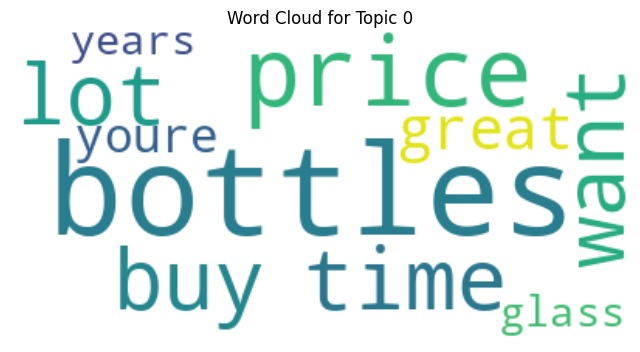

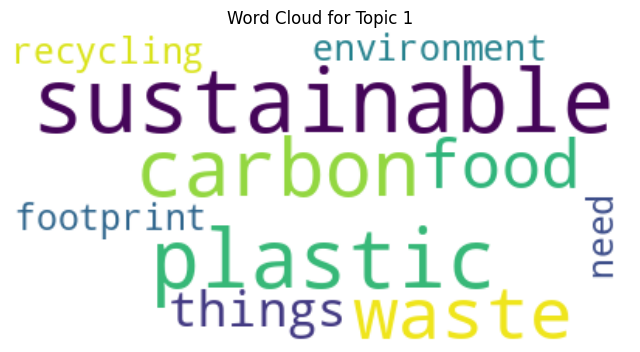

No valid words found for Topic 2
No valid words found for Topic 3
No valid words found for Topic 4
No valid words found for Topic 5
No valid words found for Topic 6
No valid words found for Topic 7
No valid words found for Topic 8
No valid words found for Topic 9


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Check if CUDA (NVIDIA GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load datasets
brand_value_comments = pd.read_excel('/content/finetune_Brand.xlsx')
reddit_comments_sustainability = pd.read_excel('/content/finetune_sustainability.xlsx')
wine_packaging_comments = pd.read_excel('/content/finetune_packaging.xlsx')

# Add KPI column
brand_value_comments['KPI'] = 'Brand Image'
reddit_comments_sustainability['KPI'] = 'Sustainability'
wine_packaging_comments['KPI'] = 'Packaging'

# Combine datasets
combined_df = pd.concat([brand_value_comments, reddit_comments_sustainability, wine_packaging_comments], ignore_index=True)

# Prepare dataset
def prepare_dataset(df):
    return {
        "text": (df['Body'] + " [KPI] " + df['KPI']).tolist(),  # Combine text with KPI for context
        "labels": df['KPI'].apply(lambda x: 0 if x == 'Brand Image' else 1 if x == 'Sustainability' else 2).tolist()
    }

prepared_data = prepare_dataset(combined_df)

# Convert to Hugging Face Dataset
dataset = Dataset.from_dict(prepared_data)

# Tokenize dataset
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Split dataset into train and test
train_test_split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Fine-tuning settings with learning rate scheduler
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_strategy="steps",
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    lr_scheduler_type='linear',
    warmup_steps=500
)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)

# Define Trainer with EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping if no improvement for 3 epochs
)

# Fine-tune the model
print("Fine-tuning on combined dataset...")
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./fine-tuned-bert-combined")
tokenizer.save_pretrained("./fine-tuned-bert-combined")

# Load the fine-tuned model for topic modeling
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained("./fine-tuned-bert-combined").to(device)
fine_tuned_tokenizer = AutoTokenizer.from_pretrained("./fine-tuned-bert-combined")

# Function to get BERT embeddings for long texts by splitting them into chunks
def get_bert_embeddings(texts):
    all_embeddings = []
    for text in texts:
        # Split text into chunks of max 512 tokens
        chunks = [text[i:i+512] for i in range(0, len(text), 512)]
        chunk_embeddings = []
        for chunk in chunks:
            encoded_input = fine_tuned_tokenizer(chunk, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
            encoded_input = {key: val.to(device) for key, val in encoded_input.items()}
            with torch.no_grad():
                model_output = fine_tuned_model(**encoded_input)
            chunk_embeddings.append(model_output.logits.mean(dim=1).cpu().numpy())
        text_embedding = np.mean(chunk_embeddings, axis=0)
        all_embeddings.append(text_embedding)
    all_embeddings = np.vstack(all_embeddings)
    return all_embeddings

# Extract topics using BERTopic
specific_comments = combined_df['Body'].dropna().astype(str).tolist()
embeddings = get_bert_embeddings(specific_comments)

# Define additional stop words specific to your context
additional_stop_words = ['wine', 'bottle', 'people', 'think', 'good', 'taste', 'smell', 'drink','dont','like','im','just','really','know','wines','use','make','ive']

# Initialize the CountVectorizer with additional stop words and refine the model
vectorizer_model = CountVectorizer(
    stop_words=list(set(CountVectorizer(stop_words="english").get_stop_words()).union(additional_stop_words)),
    max_features=5000,
    ngram_range=(1, 3)  # Include bigrams and trigrams
)

# Initialize BERTopic with the refined vectorizer
topic_model = BERTopic(vectorizer_model=vectorizer_model, min_topic_size=30)

# Fit the BERTopic model
topics, probs = topic_model.fit_transform(specific_comments, np.array(embeddings))

# Save topics to CSV
topic_info = topic_model.get_topic_info()
topics_df = pd.DataFrame(topic_info)
topics_df.to_csv('TRY1_topics_combined_refined.csv', index=False)
print("Topics saved to 'extracted_topics_combined_refined.csv'")

# Visualize the top 10 topics as word clouds
for topic_num in range(10):  # Change this to the number of topics you want to visualize
    plt.figure(figsize=(8, 6))

    # Get the topic words and their frequencies
    topic_words = topic_model.get_topic(topic_num)

    # Ensure that topic_words is a valid list of tuples
    if topic_words and isinstance(topic_words, list):
        words = dict(topic_words)
        wordcloud = WordCloud(background_color='white', colormap='viridis').generate_from_frequencies(words)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Topic {topic_num}")
        plt.show()
    else:
        print(f"No valid words found for Topic {topic_num}")
